# Trend: Bayesian smoothing

In this notebook, we will implement a Bayesian Smoothing algorithm on a binary signal to use as a source-of-truth on future signal values.

Simply, while a Bayesian filter provides a most-likely estimate of the cirrent hidden state in an HMM, using only information available at the current time, a Bayesian Smoother modifies this procedure to take future information into account. While this is not useful in designing an actionable strategy for trading, it is a useful diagnostic to evaluate the efficacy/improvements of Bayesian filters above naive observations in the absence of knowledge of the underlying state of the system.

Concretely, a Bayesian smoother provides a probability of hiden state $x_k$ taking a specific value, conditional on the *entire* sequence of observations:

$$ P(x_k | y^N) = P(x_k | y^k) \sum_{x_{k+1}} \frac{P(x_{k+1} | x_k)P(x_{k+1}|y^N)}{P(x_{k+1}| y^k)} $$

To evaluate this, we first generate feedforward estimates (using the Bayesian filter) for $P(x_k | y^k)$ and then backpropagate (iterate backwards) the sequence to determin the $P(x_{k+1}| y^N)$ terms in the summand.

Specifically, the $P(x_k | y^k)$ and $P(x_{k+1} | y^{k})$ terms are known from the forward-propagation of the Bayesian filter, while $P(x_{k+1} | x_k)$ is the transition matrix element (also assumed to be known). The only outstanding term is $P(x_{k+1}| y^N)$. However, the final entry of the sequence (when $k+1 = N$) is simply the last output of the Bayesian filter $P(x_{N} | y^N)$, which can be then used to evaluate the smoother for $P(x_{N-1}| y^{N})$. In turn, this result is used in the next iteration of the algorithm, propagating the probability back to $k=0$, and resulting in the complete filtered time series.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

# To start, build the code to run each forward simulation (dynamics,
# observations and filtered estimates)

def stochastic_matrix(a_1, a_2):
    return np.array([[1 - a_1, a_2],[a_1, 1 - a_2]])

def initialize_probability(dim=2):
    prob = np.zeros(dim)
    prob[np.random.randint(dim)] = 1
    return prob

def run_simulation_bayes(A, B, prob, bayes_est, iterations=50):
    traj_tracker = [np.argmax(prob)]
    obs_tracker = [np.argmax(prob)]
    filter_tracker = [bayes_est]

    for _ in range(iterations):
        prob = step_dynamics(prob, A)
        obs = np.argmax(step_dynamics(prob, B))
        bayes_est = bayesian_filter(A, B, bayes_est, obs)

        filter_tracker.append(bayes_est)
        traj_tracker.append(np.argmax(prob))
        obs_tracker.append(obs)

    return filter_tracker, traj_tracker, obs_tracker

def step_dynamics(p, A):
    trans_prob = A[:, np.argmax(p)]
    w = np.random.uniform()
    if w < trans_prob[0]:
        p = np.array([1, 0])
    else:
        p = np.array([0, 1])
    return p

def bayesian_filter(A: np.ndarray, B: np.ndarray, bayes_prob: np.ndarray, obs: int):
    bayes_prob = np.matmul(A, bayes_prob)           # Prediction step
    bayes_filter = B[:, obs] * bayes_prob           # Update step
    return bayes_filter / np.sum(bayes_filter)      # Normalization


In [125]:
# Initialize A and B matrices
A = stochastic_matrix(0.15, 0.15)
B = stochastic_matrix(0.25, 0.25)
bayes_est = np.array([0.5, 0.5])
prob = initialize_probability()

filter_tracker, traj_tracker, obs_tracker = run_simulation_bayes(A, B, prob, bayes_est)

In [126]:
# Now we want to back-propagate the estimates to produce a smoother estiamte
bayesian_smoother = [[]]*len(filter_tracker)
bayesian_smoother[-1] = np.array(filter_tracker[-1])

for i in range(len(filter_tracker) - 1):
    # First, calculate the 'predction' step of the Bayesian filter
    bayes_predict = np.matmul(A, filter_tracker[-(i + 2)])
    # Numerator in smoother will be element-wise product of next rpediction
    # and corresponding column of A matrix
    summand = [np.sum(bayesian_smoother[-(i + 1)] * A[:, j] / bayes_predict) for j in range(A.shape[1])]
    bayesian_smoother[-(i + 2)] = filter_tracker[-(i + 2)] * np.array(summand)


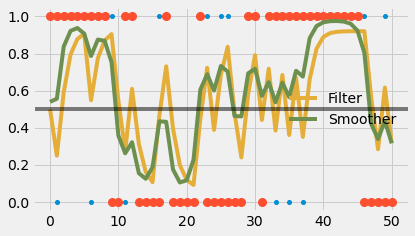

In [127]:
# Now t plot and compare the filtered vs smoothed estiamtes

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(obs_tracker, 'o', markersize=4)
ax.plot(traj_tracker, 'o', markersize=8)
ax.plot(np.array(filter_tracker)[:, 1], label="Filter")
ax.plot(np.array(bayesian_smoother)[:, 1], label="Smoother")
ax.axhline(0.5, color='k', alpha=0.5)
ax.legend(frameon=False)

In [128]:
filterError = (len(filter_tracker) - np.sum((np.array(filter_tracker)[:, 1] > 0.5) == (np.array(traj_tracker) == 1)))/len(filter_tracker)
smootherError = (len(filter_tracker) - np.sum((np.array(bayesian_smoother)[:, 1] > 0.5) == (np.array(traj_tracker) == 1))) / len(filter_tracker)

In [129]:
filterError, smootherError

(0.29411764705882354, 0.19607843137254902)

In [130]:
# We can get a more comprehensive estiamte by running the calcualtion over a longer trajectory

# First,a  routine to run the Bayesian smoothing

def bayesian_smoother(A, filter_tracker):
    bayesian_smoother = [[]]*len(filter_tracker)
    bayesian_smoother[-1] = np.array(filter_tracker[-1])

    for i in range(len(filter_tracker) - 1):
        bayes_predict = np.matmul(A, filter_tracker[-(i + 2)])
        summand = [np.sum(bayesian_smoother[-(i + 1)] * A[:, j] / bayes_predict) for j in range(A.shape[1])]
        bayesian_smoother[-(i + 2)] = filter_tracker[-(i + 2)] * np.array(summand)

    return np.array(bayesian_smoother)


In [131]:
bayes_est = np.array([0.5, 0.5])
prob = initialize_probability()

filter_tracker, traj_tracker, obs_tracker = run_simulation_bayes(A, B, prob, bayes_est, iterations=5000)
smoother_tracker = bayesian_smoother(A, filter_tracker)


In [132]:
def calc_error_rate(est_prob, state):
    n_error = len(state) - np.sum((np.array(est_prob)[:, 1] > 0.5) == (np.array(state) == 1))
    return n_error / len(state)

In [133]:
calc_error_rate(filter_tracker, traj_tracker), calc_error_rate(smoother_tracker, traj_tracker)

(0.236752649470106, 0.20655868826234752)

In [134]:
# as expected, teh error rate of the smoother estiamate is improved upon the filter itself, which should be itself an improvement upon the naive observation estimate
(len(obs_tracker) - np.sum(np.array(obs_tracker) == np.array(traj_tracker)))/len(obs_tracker)


0.2601479704059188